# Clustering Analysis

Analysis of the pre and post files of the CTI. 
It runs a k-means algorithm on the ACESTEM variables for the pre and post files.

In [1]:
# Imports
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.graph_objects as go
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.patches as mpatches

In [2]:
random.seed(2022)
np.random.seed(2022)

## Pre

In [3]:
link = "data/2021_Alumnos_pre_red.csv"
data = pd.read_csv(link)
data.head()

Codigo  Edad   Nivel Genero     Gusto  Interes_profesional  Autoeficacia  \
0   108472    13  SENIOR  Chico  3.833333             3.166667          4.25   
1   612000    14  SENIOR  Chica  4.166667             3.500000          4.75   
2   812078    15  SENIOR  Chico  4.166667             4.833333          3.00   
3   902236    14  SENIOR  Chica  4.333333             3.666667          3.50   
4  1107000    16  SENIOR  Chico  3.000000             3.000000          3.00   

   Utilidad  
0       3.8  
1       4.6  
2       4.8  
3       4.0  
4       3.0

Data for the clustering analysis

In [4]:
acestem = data[["Gusto", "Interes_profesional", "Autoeficacia", "Utilidad"]]

### Bin according to Age and Gender

In [5]:
def categorise(row):  
    if row['Edad'] <= 12:
        return 'Younger student'
    elif row['Edad'] > 12:
        return 'Older student'
    return 'Error'

In [6]:
data["Grupo_Edad"] = data.apply(lambda row: categorise(row), axis=1)

### Scaling

We scale the variables to be between 0 and 1. Since all the features have a range of 1-5, we scale them like so:

In [7]:
scaled_features = (acestem - 1)/(5-1)
scaled_features.describe()

Gusto  Interes_profesional  Autoeficacia    Utilidad
count  573.000000           573.000000    573.000000  573.000000
mean     0.767888             0.694517      0.676047    0.805585
std      0.198090             0.223698      0.184965    0.147634
min      0.000000             0.000000      0.000000    0.000000
25%      0.666667             0.541667      0.562500    0.750000
50%      0.791667             0.708333      0.687500    0.800000
75%      0.916667             0.875000      0.812500    0.900000
max      1.000000             1.000000      1.000000    1.000000

### Optimal Number of Clusters

Parameters:

- **init** controls the initialization technique. The standard version of the k-means algorithm is implemented by setting init to "random". Setting this to "k-means++" employs an advanced trick to speed up convergence.

- **n_clusters** sets k for the clustering step. This is the most important parameter for k-means.

- **n_init** sets the number of initializations to perform. This is important because two runs can converge on different cluster assignments. The default behavior for the scikit-learn algorithm is to perform ten k-means runs and return the results of the one with the lowest SSE.

- **max_iter** sets the number of maximum iterations for each initialization of the k-means algorithm.

In [8]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
silhouette_coefficients = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)
    score = silhouette_score(scaled_features, kmeans.labels_)
    silhouette_coefficients.append(score)

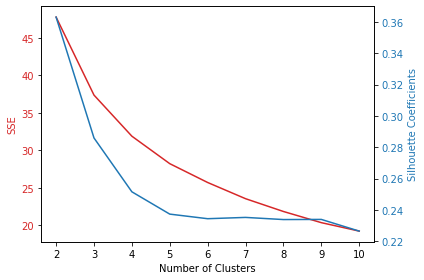

In [9]:
x = range(2,11)

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('SSE', color=color)
ax1.plot(x, sse, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Silhouette Coefficients', color=color)  # we already handled the x-label with ax1
ax2.plot(x, silhouette_coefficients, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Looking at both meassures, the optimal number of clusters is between 3 and 4 clusters

### K-Means Clustering k = 3

In [10]:
In [7]: kmeans = KMeans(
    init="random",
    n_clusters=3,
    n_init=10,
    max_iter=300,
    random_state=42)

In [11]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(scaled_features)

KMeans(n_clusters=3)

In [12]:
data["label"] = kmeans.labels_
data.head()

Codigo  Edad   Nivel Genero     Gusto  Interes_profesional  Autoeficacia  \
0   108472    13  SENIOR  Chico  3.833333             3.166667          4.25   
1   612000    14  SENIOR  Chica  4.166667             3.500000          4.75   
2   812078    15  SENIOR  Chico  4.166667             4.833333          3.00   
3   902236    14  SENIOR  Chica  4.333333             3.666667          3.50   
4  1107000    16  SENIOR  Chico  3.000000             3.000000          3.00   

   Utilidad     Grupo_Edad  label  
0       3.8  Older student      2  
1       4.6  Older student      2  
2       4.8  Older student      0  
3       4.0  Older student      2  
4       3.0  Older student      1

### Cluster composition

In [13]:
centers = pd.DataFrame(kmeans.cluster_centers_, columns = ['Gusto', 'Interes_profesional', 'Autoeficacia', 'Utilidad'])
centers

Gusto  Interes_profesional  Autoeficacia  Utilidad
0  0.916667             0.892906      0.773760  0.878306
1  0.425926             0.362037      0.502083  0.646667
2  0.746196             0.619467      0.642894  0.791909

- **Cluster 0** : students who have high scores in all ACESTEM variables
- **Cluster 1** : students who have low scores in all ACESTEM variables
- **Cluster 2**: students who have medium scores in all ACESTEM variables

### Representation

In [14]:
data.label.value_counts().sort_index()

0    242
1     90
2    241
Name: label, dtype: int64

<AxesSubplot: >

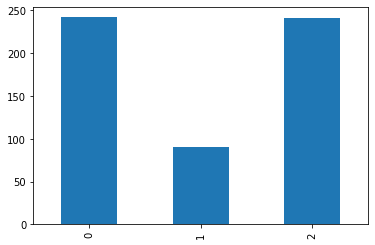

In [15]:
data.label.value_counts().sort_index().plot(kind = 'bar')

- Most students belong to cluster 0 (242) and 2 (241) (high and medium ACESTEM scores)
    - Expected because students who attend a science camp tend to have high ACESTEM scores
- Few students belong to cluster 1 (90)

#### Gender distribution

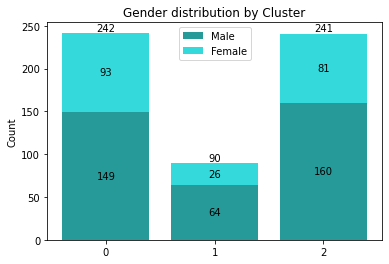

In [16]:
labels = ['0', '1', '2']
men = data[data.Genero == 'Chico'].label.value_counts().sort_index().values
women = data[data.Genero == 'Chica'].label.value_counts().sort_index().values

# width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()

p1 = ax.bar(labels, men, label='Male' , color=(0.15, 0.6, 0.6))
p2 = ax.bar(labels, women, bottom=men, label='Female', color=(0.2, 0.85, 0.86))

ax.bar_label(p1, label_type='center')
ax.bar_label(p2, label_type='center')
ax.bar_label(p2)

ax.set_ylabel('Count')
ax.set_title('Gender distribution by Cluster')
ax.legend()

plt.show()

#### Age Distribution

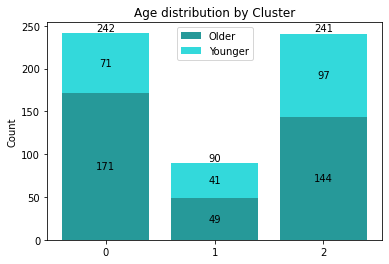

In [17]:
labels = ['0', '1', '2']

older = data[data.Grupo_Edad == 'Older student'].label.value_counts().sort_index().values
younger = data[data.Grupo_Edad == 'Younger student'].label.value_counts().sort_index().values

# width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()

p1 = ax.bar(labels, older, label='Older', color=(0.15, 0.6, 0.6))
p2 = ax.bar(labels, younger, bottom=older, label='Younger', color=(0.2, 0.85, 0.86))

ax.bar_label(p1, label_type='center')
ax.bar_label(p2, label_type='center')
ax.bar_label(p2)

ax.set_ylabel('Count')
ax.set_title('Age distribution by Cluster')
ax.legend()

plt.show()

#### Cluster Representation

In [18]:
sns.pairplot(data, hue ='label')

### Save Clusters

In [19]:
data.to_csv("data/2021_pre_clusters.csv", index = False)

## Post

We are going to use the clusters from the pre to classify the post answers

In [20]:
link = "data/2021_Alumnos_post_red.csv"
data = pd.read_csv(link)
data.head()

Codigo   Nivel Genero     Gusto  Interes_profesional  Autoeficacia  \
0   108472.0  SENIOR  Chico  3.333333             3.166667          4.50   
1   401577.0  SENIOR  Chica  5.000000             5.000000          4.75   
2   611283.0  SENIOR  Chica  3.666667             3.333333          4.75   
3   902236.0  SENIOR  Chica  4.333333             4.000000          3.75   
4  1107156.0  SENIOR  Chico  4.666667             5.000000          4.50   

   Utilidad  
0       3.8  
1       4.4  
2       4.6  
3       4.0  
4       4.2

In [21]:
acestem = data[["Gusto", "Interes_profesional", "Autoeficacia", "Utilidad"]]

### Scaling

In [22]:
scaled_features = (acestem - 1)/(5-1)
scaled_features.describe()

Gusto  Interes_profesional  Autoeficacia    Utilidad
count  747.000000           747.000000    747.000000  747.000000
mean     0.795571             0.719322      0.682145    0.824766
std      0.197704             0.229393      0.207068    0.155342
min      0.000000             0.000000      0.000000    0.000000
25%      0.708333             0.583333      0.500000    0.750000
50%      0.833333             0.750000      0.687500    0.850000
75%      0.958333             0.916667      0.812500    0.950000
max      1.000000             1.000000      1.000000    1.000000

### Predict

In [27]:
data["label"] = kmeans.predict(scaled_features)
data

Codigo   Nivel Genero     Gusto  Interes_profesional  Autoeficacia  \
0     108472.0  SENIOR  Chico  3.333333             3.166667          4.50   
1     401577.0  SENIOR  Chica  5.000000             5.000000          4.75   
2     611283.0  SENIOR  Chica  3.666667             3.333333          4.75   
3     902236.0  SENIOR  Chica  4.333333             4.000000          3.75   
4    1107156.0  SENIOR  Chico  4.666667             5.000000          4.50   
..         ...     ...    ...       ...                  ...           ...   
742  2101024.0  SENIOR  Chica  4.166667             4.166667          4.50   
743  2703000.0  SENIOR  Chico  3.666667             3.166667          4.00   
744  2908377.0  SENIOR  Chico  3.166667             2.166667          3.75   
745  2912000.0  SENIOR  Chico  4.833333             5.000000          4.00   
746  3008623.0  SENIOR  Chica  4.666667             4.333333          3.25   

     Utilidad  label  
0         3.8      2  
1         4.4      0  
2         4.6      2  
3         4.0      2  
4         4.2      0  
..        ...    ...  
742       4.4      0  
743       4.0      2  
744       3.6      1  
745       4.4      0  
746       4.8      0  

[747 rows x 8 columns]

### Save Clusters

In [28]:
data.to_csv("data/2021_post_clusters.csv", index = False)

## Flow Diagram

In [29]:
pre = pd.read_csv("data/2021_pre_clusters.csv")
pre = pre.drop_duplicates(subset = 'Codigo')
pre = pre[["Codigo", "label"]]
pre.head()

Codigo  label
0   108472      2
1   612000      2
2   812078      0
3   902236      2
4  1107000      1

In [30]:
post = pd.read_csv("data/2021_post_clusters.csv")
post = post.drop_duplicates(subset = 'Codigo', keep = 'last')
post = post[["Codigo", "label"]]
post.head()

Codigo  label
2    611283.0      2
3    902236.0      2
4   1107156.0      0
9   2308161.0      0
10  2409000.0      2

In [31]:
pre_post = pre.merge(post, on = 'Codigo')
pre_post

C:\Users\Maria\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


Codigo  label_x  label_y
0     108472        2        1
1     902236        2        2
2    1107000        1        2
3    1107156        0        0
4    1711134        0        0
..       ...      ...      ...
333  2101024        0        0
334  2703000        2        2
335  2908377        1        1
336  2912000        0        0
337  3008623        0        0

[338 rows x 3 columns]

In [32]:
count = pre_post[["label_x", "label_y"]].value_counts().sort_index()
count

label_x  label_y
0        0          130
         1            1
         2           23
1        0            4
         1           32
         2           10
2        0           31
         1           12
         2           95
dtype: int64

In [38]:
source = []
target = []
value = []
for i in range(len(count)):
    source.append(count.index[i][0])
    target.append(count.index[i][1] + 3)
    value.append(count.values[i])

In [55]:
color_link = ['#AEFCAF', '#FCB9AE', '#FAFCAE', '#AEFCAF', '#FCB9AE', '#FAFCAE', '#AEFCAF', '#FCB9AE', '#FAFCAE']
link = dict(source = source, target = target, value = value, color = color_link)

label = ["C0", "C1", "C2", "C0", "C1", "C2"]
color_node = ['#73E075','#E07373','#E0DE73','#73E075','#E07373', '#E0DE73']
line = dict(color = None, width = 0.01)
node = dict(label = label, color = color_node, line = line)

data = go.Sankey(link = link, node =  node)

fig = go.Figure(data)

fig.update_layout(title_text="<b>Sankey Diagram</b><br>Pre-Post CTI Cluster Flow", font_size=10, margin=dict(t=100,l=0,b=20,r=30))

fig.show()